In [101]:
import torch.nn as nn
import torch
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# from model import SoundExtractor, SoundClassifier
from models import *
from fighting_dataset import *
from utility import *
import math

In [61]:
x_train, y_train, x_val, y_val, x_test, y_test, sampling_rate, train_type = load_fighting_dataset_without_matlab(hop_legnth=20, data_aug=False, useless_data=[])

# 레이블별 사운드 분류

In [23]:
def segment_sound_gyeore(sound, label, sampling_rate, hop_length):
    # hop_length = hop_length 
    window_size = int(hop_length * 2)
    result_data = np.zeros((100, window_size))
    result_label = []
    total_count = 0
    less_length = 0
    
    for i, y in enumerate(sound):
        # y = center_crop(y, label[i], sampling_rate*20, len(y)//2)
        if label[i] == 'crowd':
            y = center_crop(y, len(y)//4)
        elif label[i] == 'epic':
            y = center_crop(y, len(y)//4)
        if len(y) < window_size:
            less_length += 1
            print("sound length is less than 40 ms", less_length)
            continue
        
        D = np.abs(librosa.stft(y, n_fft=window_size, win_length = window_size, hop_length=hop_length, center=False))
        mel_spec = librosa.feature.melspectrogram(S=D, sr=sampling_rate, n_mels=64, hop_length=hop_length, win_length=window_size)
        amplitude = librosa.amplitude_to_db(mel_spec, ref=1.0)
        o_env = librosa.onset.onset_strength(y=y, sr=sampling_rate, S=amplitude)   
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sampling_rate, hop_length=hop_length)
        times = librosa.times_like(o_env, sr=sampling_rate, hop_length=hop_length)
        
        ipd.display(Audio(sound, rate=sampling_rate))
        fig, ax = plt.subplots(nrows=3, sharex=True)
        librosa.display.specshow(amplitude, x_axis='time', y_axis='log', ax=ax[0])
        ax[0].set(title='Power spectrogram')
        ax[0].label_outer()
        ax[1].plot(times, o_env, label='Onset strength')
        ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
                linestyle='--', label='Onsets')
        ax[1].legend()
        ax[1].axis(xmin=0, xmax=len(y)/sampling_rate)
        ax[2].plot(np.linspace(0, len(y)/sampling_rate, len(y)), y)
        ax[2].vlines(times[onset_frames], 0, 1, color='r', alpha=0.9,
                linestyle='--', label='Onsets')
        ax[2].legend(['signal', 'onsets'])
        plt.show()
        
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sampling_rate, hop_length=hop_length, units='samples')
        for sample in onset_frames:
            if sample >= len(y) - window_size:
                print('continue')
                continue               
            result_data[total_count] = y[sample:sample+window_size]
            total_count += 1
            result_label += [label[i]]
    
    print("the number of total sound segment: %d"%(total_count))
    print("the number of sounds of which length is less than 40ms: %d"%(less_length))
    return result_data[:total_count], np.array(result_label)

In [ ]:
import IPython.display as ipd
from IPython.display import Audio

filepath = os.path.join('.', 'dataset', 'Fighting')
label_name = os.listdir(filepath)
for label in label_name:
    folder_name = os.listdir(os.path.join(filepath, label))
    for folder in folder_name:
        # if folder.lower() in useless_data:
        #     print("{}-{} not used".format(label, folder))
        #     continue
        file_name = os.listdir(os.path.join(filepath, label, folder))
        for sound_name in file_name:
            sound_file_path = os.path.join(filepath, label, folder, sound_name)
            print('label: {}, sound source: {}, file name: {}'.format(label, folder, sound_name))
            sound, sr = torchaudio.load(sound_file_path)
            sampling_rate = 44100
            if sound.shape[0] == 2:
                sound = torch.mean(sound, dim=0).view(1, -1) # 겨레형이 loudness 구할 때 평균내서 사용하였음.
            sound = torchaudio.functional.resample(sound, orig_freq=sr, new_freq=sampling_rate).numpy()
            # sound = sound[0].numpy()
            hop_length = 882
            window_size = int(hop_length*2)        
            
            sound_list, _ = segment_sound_gyeore(sound, list(label), sampling_rate, hop_length=hop_length)

            for i in range(len(sound_list)):
                ipd.display(Audio(sound_list[i], rate=sampling_rate))
                print(sound_list[i].shape)
                D = np.abs(librosa.stft(sound_list[i], n_fft=window_size, win_length = window_size, hop_length=hop_length, center=True))
                S_db = librosa.amplitude_to_db(D, ref=1.0)
                
                fig, ax = plt.subplots()
                img = librosa.display.specshow(S_db, x_axis='ms', y_axis='linear', ax=ax, sr=sampling_rate)
                ax.set(title='Using a logarithmic frequency axis')
                fig.colorbar(img, ax=ax, format="%+2.f dB")
                plt.savefig('temp.png', dpi=300)
                plt.show()         
                
                _ = input()
            plt.clf()

## 랜덤한 사운드에 대한 spectogram

In [ ]:
import IPython.display as ipd
from IPython.display import Audio
import pandas as pd

filepath = os.path.join('.', 'dataset', 'Fighting')
label_name = os.listdir(filepath)

filepath_list = []
label_list = []
folder_list = []
sound_name_list = []

for label in label_name:
    print(label)
    folder_name = os.listdir(os.path.join(filepath, label))
    for folder in folder_name:
        # if folder.lower() in useless_data:
        #     print("{}-{} not used".format(label, folder))
        #     continue
        file_name = os.listdir(os.path.join(filepath, label, folder))
        for sound_name in file_name:
            sound_file_path = os.path.join(filepath, label, folder, sound_name)
            
            filepath_list.append(filepath)
            label_list.append(label)
            folder_list.append(folder)
            sound_name_list.append(sound_name)

shuffle_index = np.arange(len(filepath_list))
shuffle_index = np.arange(len(filepath_list))
np.random.shuffle(shuffle_index)

for i in shuffle_index:
    filepath = filepath_list[i]
    label = label_list[i]
    folder = folder_list[i]
    sound_name = sound_name_list[i]

    print('label: {}, sound source: {}, file name: {}'.format(label, folder, sound_name))
    sound_file_path = os.path.join(filepath, label, folder, sound_name)
    sound, sr = torchaudio.load(sound_file_path)
    sampling_rate = 44100
    if sound.shape[0] == 2:
        sound = torch.mean(sound, dim=0).view(1, -1)
    sound = torchaudio.functional.resample(sound, orig_freq=sr, new_freq=sampling_rate).numpy()
    # sound = sound[0].numpy()
    hop_length = 882
    window_size = int(hop_length*2)        

    sound_list, _ = segment_sound_gyeore(sound, list(label), sampling_rate, hop_length=hop_length)

    for i in range(len(sound_list)):
        ipd.display(Audio(sound_list[i], rate=sampling_rate))
        print(sound_list[i].shape)
        D = np.abs(librosa.stft(sound_list[i], n_fft=window_size, win_length = window_size, hop_length=hop_length, center=True))
        S_db = librosa.amplitude_to_db(D, ref=1.0)
        # print('D shape : {}, S_db shape : {}'.format(D.shape, S_db.shape))
        
        fig, ax = plt.subplots()
        img = librosa.display.specshow(S_db, x_axis='ms', y_axis='linear', ax=ax, sr=44100)
        ax.set(title='Using a logarithmic frequency axis')
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        plt.savefig('temp.png', dpi=300)
        plt.show()         
        
        _ = input()

## 특정 사운드에 대한 onset detetion plotting

the number of onsets : [ 33  81 133]


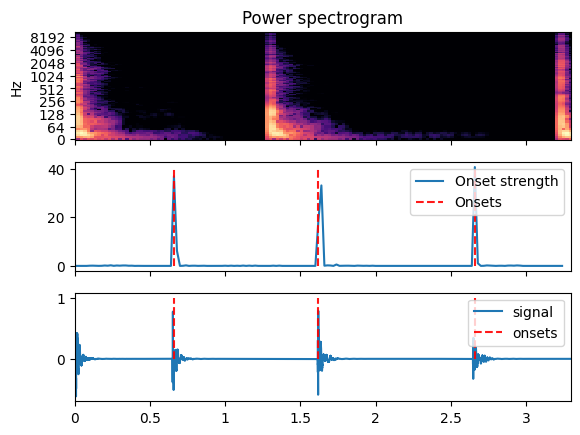

In [233]:
n_mels = 64
hop_length = 882
window_size = int(hop_length*2)
sampling_rate = 44100

filepath = os.path.join('dataset', 'Fighting', 'attack', 'Artlist', 'Céline Woodburn - Dissection - Punch, Body Thud, Multiple.wav')
sound, sr = torchaudio.load(filepath)
sampling_rate = 44100
if sound.shape[0] == 2:
    sound = torch.mean(sound, dim=0).view(1, -1)
sound = torchaudio.functional.resample(sound, orig_freq=sr, new_freq=sampling_rate).numpy()
# sound = torch.mean(sound, dim=0).view(1, -1)
y = sound[0]

D = np.abs(librosa.stft(y, n_fft=window_size, win_length = window_size, hop_length=hop_length, center=False))
mel_spec = librosa.feature.melspectrogram(S=D, sr=sampling_rate, n_mels=n_mels, hop_length=hop_length, win_length=window_size)
amplitude = librosa.amplitude_to_db(mel_spec, ref=1.0)
o_env = librosa.onset.onset_strength(y=y, sr=sampling_rate, S=amplitude)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sampling_rate, hop_length=hop_length)
print('the number of onsets : {}'.format(onset_frames))

times = librosa.times_like(o_env, sr=sampling_rate, hop_length=hop_length)
# onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=3, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
ax[1].legend()
ax[1].axis(xmin=0, xmax=len(y)/sampling_rate)
ax[2].plot(np.linspace(0, len(y)/sampling_rate, len(y)), y)
ax[2].vlines(times[onset_frames], 0, 1, color='r', alpha=0.9,
           linestyle='--', label='Onsets')
ax[2].legend(['signal', 'onsets'])
# plt.show()
# plt.plot(np.linspace(0, len(y)/sampling_rate, len(y)), y)
# plt.vlines(times[onset_frames], 0, 1, color='r', alpha=0.9,
#            linestyle='--', label='Onsets')
# plt.legend(['signal', 'onsets'])
# plt.show()

## Energy와 onset detection 비교 

In [298]:
def segment_sound_energy(sound, label, sampling_rate, hop_length):
    # hop_length = hop_length 
    window_size = int(hop_length * 2)
    result_data = np.zeros((300, window_size))
    result_label = []
    total_count = 0
    less_length = 0
    
    label_dic = {
        "attack" : 0,
        "crowd" : 1,
        "epic" : 2,
        "exciting" : 3,
        "voice" : 4,
        "whoosh" : 5
    }
    
    for i, y in enumerate(sound):
        # y = center_crop(y, label[i], sampling_rate*20, len(y)//2)
        if label[i] == 'crowd':
            y = center_crop(y, len(y)//4)
        elif label[i] == 'epic':
            y = center_crop(y, len(y)//4)
        if len(y) < window_size:
            less_length += 1
            print("sound length is less than 40 ms", less_length)
            continue
        
        # Onset detection
        D = np.abs(librosa.stft(y, n_fft=window_size, win_length = window_size, hop_length=hop_length, center=False))
        mel_spec = librosa.feature.melspectrogram(S=D, sr=sampling_rate, n_mels=64, hop_length=hop_length, win_length=window_size)
        amplitude = librosa.amplitude_to_db(mel_spec, ref=1.0)
        o_env = librosa.onset.onset_strength(y=y, sr=sampling_rate, S=amplitude)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sampling_rate, hop_length=hop_length, units='samples')
           
        
        # energy 계산 
        # attack, whoosh, voice도의 경우 전체 사운드에서 1개 / crowd, epic, exciting의 경우 1초마다 1개씩
        # print(label_dic[label], type(label_dic[label]))
        if label_dic[label] in [0, 4, 5]:
            max_onset = 1 # 전체 사운드에서 1개
        elif label_dic[label] in [1, 2, 3]:
            max_onset = 1000 # 1000개 넘는건 없겠지
        
        onset_count = 0
        start_point = 0
        energy_list = []
        peak_energy_list = []
        energy_window_size = int(20 * sampling_rate / 1000)
        energy_hop_length = int(10 * sampling_rate / 1000)
        ##################################
        # start_point + energy_window_size < len(y)) 를 start_point + sapling_rate < len(y))로 바꿔줘야 함.
        while (onset_count < max_onset and start_point + energy_window_size < len(y)):   
            if len(y) < sampling_rate: # 일단 1초보다 작으면 그래도 하나는 해주자.
                end_point = len(y)
            # 1초가 안되면 다 잘라버리기
            # elif start_point + energy_window_size >= len(y):
            #     end_point = len(y)
            else:
                end_point = start_point + sampling_rate - 1
                
            # energy_index = [[i, i+energy_window_size] for i in range(start_point, end_point, energy_hop_length) if i + energy_window_size <= end_point]
            # 억지로 list comprehension 하지 말고 하나씩 해보자.
            print('start and end point: {} and {}'.format(start_point, end_point))
            print('legnth of the sound: {}'.format(len(y)))
            energy_index = []
            index = start_point
            while index + energy_window_size <= end_point:
                energy_index.append([index, index + energy_window_size])
                index += energy_hop_length
            # print(energy_index)
            
            energy = [y[index[0]:index[1]] for index in energy_index]
            energy = np.array(energy)
            for i in range(len(energy)):
                print(len(energy[i]), 'index: {}~{}'.format(energy_index[i][0], energy_index[i][1]))
            
            energy = (np.sum(energy, axis=1) * np.sum(energy, axis=1)).reshape(-1)
            # print('energy shape: ', energy.shape)
            peak_index = np.argmax(energy, axis=0)
            # peak_index = math.floor(peak_index / len(energy) * sampling_rate)
            # energy_list = [value if i == peak_index else 0 for i, value in enumerate(energy)]
            
            # energy_list.append(energy)
            # peak_energy_list.append(start_point + peak_index)
            peak_energy_list.append(len(energy_list) + peak_index)
            energy_list.extend(energy.tolist())
            # print('length of energy : {}, peak energy index : {}'.format(len(energy_list), peak_index))
    
            # 초당 한 개 씩
            start_point = end_point + 1
            onset_count += 1
            
        print('peak energy samples: ', peak_energy_list)
        print('length of energy list: ', len(energy_list))
        print(min(energy_list), sum(energy_list)/len(energy_list), max(energy_list))
            
        print('window size : {}, hop size : {}'.format(window_size, hop_length))
        print('onset samples: ', onset_frames)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sampling_rate, hop_length=hop_length)
        times = librosa.times_like(o_env, sr=sampling_rate, hop_length=hop_length)
        print('onset samples: ', times[onset_frames])
            
        # Plot onset detection
        # 특정 값만 색 변경 https://datacook.tistory.com/61
        # peak_energy_list_ = [i if i in peak_energy_list else 0 for i in range(len(y))]
        ipd.display(Audio(sound, rate=sampling_rate))
        
        # fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(16, 16))
        plt.figure(figsize=(16, 16))
        plt.subplot(4,1,1)
        librosa.display.specshow(amplitude, x_axis='time', y_axis='log')
        plt.title('Power spectrogram')
        # ax[0].set_xlim(left=0, right=len(amplitude))
        # plt.label_outer()
        
        # ax[1].set_xlim(left=0, right=len(times))
        plt.subplot(4,1,2)
        plt.plot(times, o_env, label='Onset strength')
        plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
                linestyle='--', label='Onsets')
        plt.legend()
        plt.axis(xmin=0, xmax=len(y)/sampling_rate)
        plt.xlim(left=0)
        
        plt.subplot(4,1,3)
        x_axis = np.linspace(0, len(y)/sampling_rate, len(y))
        plt.plot(x_axis, y)
        plt.vlines(times[onset_frames], 0, 1, color='r', alpha=0.9,
                linestyle='--', label='Onsets')
        plt.legend(['signal', 'onsets'])
        plt.xlim(left=0)
        
        plt.subplot(4,1,4)
        energy_axis = np.arange(0, len(energy_list))
        plt.xlim(left=0, right=len(energy_list)-1)
        plt.plot(energy_axis, energy_list)
        plt.vlines(energy_axis[peak_energy_list], 0, max(energy_list), color='purple',  alpha=0.9,
                linestyle='--', label='Energys')
        
        plt.legend(['energy', 'max energy point'])
        plt.xlim(left=0)
        plt.show()
        
        # onset detection으로 segmentation
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sampling_rate, hop_length=hop_length, units='samples')
        print('samples: ', onset_frames)
        for sample in onset_frames:
            if sample >= len(y) - window_size:
                print('continue')
                continue               
            result_data[total_count] = y[sample:sample+window_size]
            total_count += 1
            result_label += [label[i]]
                
    print("the number of total sound segment: %d"%(total_count))
    print("the number of sounds of which length is less than 40ms: %d"%(less_length))
    return result_data[:total_count], np.array(result_label), energy_list, peak_energy_list

def find_max_energy_point(sound, onset_max, window_size=20, hop_length=10, sampling_rate=44100):
    window_size = (window_size * sampling_rate / 1000)
    hop_length = (hop_length * sampling_rate / 1000)
    
    energy_list = []
    peak_list = []
    
    if onset_max == 1:
        end_point = len(sound)
        energy_index = []
        index = 0
        # energy_index = [[i, i+window_size] for i in range(start_point, end_point, hop_length) if i + window_size <= end_point]
        while index + window_size < len(y):
            energy_index.append([index, index + window_size])
            index += hop_length
        energy = np.array([y[index[0]:index[1]] for index in energy_index])
        assert len(energy.shape) == 2
        energy_point = (np.sum(energy, axis=1) * np.sum(energy, axis=1)).reshape(-1)
        peak_index = np.argmax(energy, axis=0)
        # peak_index = math.floor(peak_index / len(energy) * sampling_rate) -> index 기준을 energy에서 sound로 변경
        
        # peak_list.append(len(energy_list) + peak_index)
        peak_list.append(peak_index) 
        energy_list.extend(energy_point.tolist())
    else:
        start_point = 0
        onset_count = 0
        index = start_point
        while(onset_count < onset_max and start_point + sampling_rate < len(y)):
            # 1초마다 maximum energy point 계산
            end_point = start_point + sampling_rate
            energy_index = []

            while index + window_size < end_point:
                energy_index.append([index, index + window_size])
                index += hop_length
            energy = np.array([y[index[0]:index[1]] for index in energy_index])
            assert len(energy.shape) == 2
            energy_point = (np.sum(energy, axis=1) * np.sum(energy, axis=1)).reshape(-1)
            peak_index = np.argmax(energy, axis=0)
            
            peak_list.append(len(energy_list) + peak_index)
            energy_list.extend(energy_point.tolist())
            
          

peak energy가 없거나(ES_Sparring Glove 13 - SFX Producer.wav) index out of range가 나오는 경우가 있음.

또한 0321 안되는 곳 폴더에 말이 안되는 (signal 많은쪽에서 maximum이 안잡히고 다른곳에서 잡히고 있음.)게 있음
> 따라서 반드시 energy 계산하는거 다시해봐야 함 >


에너지 계산 공식 확인하고, window가 제대로 이루어지는지 확인할 필요가 있음.

In [ ]:
import IPython.display as ipd
from IPython.display import Audio
import pandas as pd

filepath = os.path.join('.', 'dataset', 'Fighting')
label_name = os.listdir(filepath)

filepath_list = []
label_list = []
folder_list = []
sound_name_list = []

for label in label_name:
    print(label)
    folder_name = os.listdir(os.path.join(filepath, label))
    for folder in folder_name:
        # if folder.lower() in useless_data:
        #     print("{}-{} not used".format(label, folder))
        #     continue
        file_name = os.listdir(os.path.join(filepath, label, folder))
        for sound_name in file_name:
            sound_file_path = os.path.join(filepath, label, folder, sound_name)
            
            filepath_list.append(filepath)
            label_list.append(label)
            folder_list.append(folder)
            sound_name_list.append(sound_name)

shuffle_index = np.arange(len(filepath_list))
np.random.seed(42)
np.random.shuffle(shuffle_index)

for i in shuffle_index:
    filepath = filepath_list[i]
    label = label_list[i]
    folder = folder_list[i]
    sound_name = sound_name_list[i]

    print('label: {}, sound source: {}, file name: {}'.format(label, folder, sound_name))
    sound_file_path = os.path.join(filepath, label, folder, sound_name)
    sound, sr = torchaudio.load(sound_file_path)
    sampling_rate = 44100
    if sound.shape[0] == 2:
        sound = torch.mean(sound, dim=0).view(1, -1)
    sound = torchaudio.functional.resample(sound, orig_freq=sr, new_freq=sampling_rate).numpy()
    # sound = sound[0].numpy()
    hop_length = 882
    window_size = int(hop_length*2)        

    sound_list, _,  energy_list, peak_index = segment_sound_energy(sound, label, sampling_rate, hop_length=hop_length)

    for i in range(len(sound_list)):
        ipd.display(Audio(sound_list[i], rate=sampling_rate))
        D = np.abs(librosa.stft(sound_list[i], n_fft=window_size, win_length = window_size, hop_length=hop_length, center=True))
        S_db = librosa.amplitude_to_db(D, ref=1.0)
        
        fig, ax = plt.subplots()
        img = librosa.display.specshow(S_db, x_axis='ms', y_axis='linear', ax=ax, sr=44100)
        ax.set(title='Using a logarithmic frequency axis')
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        plt.savefig('temp.png', dpi=300)
        plt.show()         
        
    _ = input()
    print('-------------------------------------------------------------------------------')

attack, whoosh의 경우 전체에서 1개...? 

만약에 여러개 한다면..? -> 겨레형 말 처럼 걍 attack, whoosh의 경우 전체 사운드에서 1개 / crowd, epic, exciting의 경우 1초마다 1개씩 / voice도 전체 사운드에서 1개?

- 신호의 크기를 비교했는데, 뒤가 작으면 무시해도 되는 것 아니냐?
    - duration을 고려
- 여러 개의 attack이 있는 경우?
    - 작아지다가 커지면 다른 사람 취급한다.
- onset이 펀치가 일어나는 순간이 아니라 window를 이용하여 펀치를 확인한다.
    - onset detection이 punch 소리를 detetion해도 window가 전부는 안들어 갈 수 있음. → window의 크기를 조절하라는 의미같음.

In [297]:
# label = 'attack'
# source = 'Epidemic Sound'
# filename = 'ES_Body Hit Slap 2 - SFX Producer.wav'
label = 'crowd'
source = 'SONIC BAT - Soccer Stadium Ambience'
filename = 'SBssa_Crowd Booing 003.wav'

path = os.path.join('.', 'dataset', 'Fighting', label, source, filename)
[sound, sr] = torchaudio.load(path)
if sound.shape[0] == 2:
    sound = torch.mean(sound, dim=0).view(1, -1)
    
sampling_rate = 44100
start_point = 0
if len(y) < sampling_rate:
    end_point = len(y)
else:
    end_point = sampling_rate - 1    
    
sound = torchaudio.functional.resample(sound, orig_freq=sr, new_freq=sampling_rate).numpy()
y = sound[0]
sound_list, _,  energy_list, peak_index = segment_sound_energy(sound, label, sampling_rate, hop_length=hop_length)

energy_window_size = int(20 * 44100 / 1000)
energy_hop_length = int(10 * 44100 / 1000)

energy_index = [[i, i+energy_window_size] for i in range(start_point, end_point, energy_hop_length) if i + energy_window_size < end_point]
# energy_index = []
# index = start_point
# while index + energy_window_size <= end_point:
#     print([index, index + energy_window_size])
#     energy_index.append([index, index + energy_window_size])
#     index += energy_hop_length
# print(energy_index)

energy = [y[index[0]:index[1]] for index in energy_index]
energy = np.array(energy)
# for i in range(len(energy)):
#     print(len(energy[i]))

energy = (np.sum(energy, axis=1) * np.sum(energy, axis=1)).reshape(-1)
plt.plot(energy)

peak_index = np.argmax(energy, axis=0)

# x_axis = np.linspace(0, e, )
x_axis = np.arange(0, len(energy))
plt.plot(x_axis, energy, color='skyblue')
plt.vlines(x_axis[peak_index], 0, max(energy), color='r', alpha=0.9, linestyle='--', label='Onsets')
plt.show()

# ax[2].vlines(times[onset_frames], 0, 1, color='r', alpha=0.9,
#         linestyle='--', label='Onsets')
# ax[2].legend(['signal', 'onsets'])

peak_index = math.floor(peak_index / len(energy) * sampling_rate)
# energy_list = [value if i == peak_index else 0 for i, value in enumerate(energy)]
# peak_energy_list.append(start_point + peak_index)
print(peak_index)



start and end point: 0 and 44099
legnth of the sound: 595350
882 index: 0~882
882 index: 441~1323
882 index: 882~1764
882 index: 1323~2205
882 index: 1764~2646
882 index: 2205~3087
882 index: 2646~3528
882 index: 3087~3969
882 index: 3528~4410
882 index: 3969~4851
882 index: 4410~5292
882 index: 4851~5733
882 index: 5292~6174
882 index: 5733~6615
882 index: 6174~7056
882 index: 6615~7497
882 index: 7056~7938
882 index: 7497~8379
882 index: 7938~8820
882 index: 8379~9261
882 index: 8820~9702
882 index: 9261~10143
882 index: 9702~10584
882 index: 10143~11025
882 index: 10584~11466
882 index: 11025~11907
882 index: 11466~12348
882 index: 11907~12789
882 index: 12348~13230
882 index: 12789~13671
882 index: 13230~14112
882 index: 13671~14553
882 index: 14112~14994
882 index: 14553~15435
882 index: 14994~15876
882 index: 15435~16317
882 index: 15876~16758
882 index: 16317~17199
882 index: 16758~17640
882 index: 17199~18081
882 index: 17640~18522
882 index: 18081~18963
882 index: 18522~19404


C:\Users\Interaction Lab\AppData\Local\Temp\ipykernel_34176\1081961414.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  energy = np.array(energy)


AxisError: axis 1 is out of bounds for array of dimension 1